# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Voting Classifier Model

In this notebook, you will create the voting classifier model which will aggregate the predicted output of multiple machine learning models and provide the final predicted output.

The notebook is structured as follows:
1. [Import Libraries and Data](#import)
2. [Split Data into Train and Test and Scale the Features](#scale)
3. [Implement Voting Classifier](#vote)
4. [Conclusion](#conclusion)

<a id='import'></a>
## Import Libraries and Data

You will use the `pandas` and `numpy` libraries for data storage and manipulation. You will use the XGBoost, Logistic Regression, and Support Vector Machine ML models which will be used by the voting classifier to predict the final output. You will be using the `xgboost` and `sklearn` libraries for using the different ML models.

You will import the file `sp500_features_Jan_2009_June_2022.csv` which contains the OHLCV data of the SPDR S&P 500 ETF (ticker: SPY) from January 2009 to June 2022, along with the features that were calculated in the `Decision Tree` sections.

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For machine learning models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

# For calculating accuracy scores of different ML models
from sklearn.metrics import accuracy_score

# For splitting the data into train and test
from sklearn.model_selection import train_test_split

# For data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Import warnings
import warnings
warnings.filterwarnings('ignore')

# Read data file using read_csv method of pandas
spy = pd.read_csv(
    '../data_modules/sp500_features_Jan_2009_June_2022.csv', index_col=0)
# Print the last 5 rows of the SPY ETF values with features
spy.tail()

,Open,High,Low,Close,Volume,f_ret_1,f_ret_5,f_ret_10,f_natr,f_rsi,f_norm_upper,f_norm_lower,f_norm_middle,target
Date,,,,,,,,,,,,,,
2022-06-23,373.384588,375.555631,369.667000,374.792297,79292100,0.009803,0.001300,-0.076667,2.564619,41.207038,1.010850,0.955454,0.983152,0.031794
2022-06-24,378.103436,386.718328,378.073696,386.708405,98050300,0.031794,0.068499,-0.024101,2.528335,49.154390,1.005813,0.925544,0.965679,-0.003820
2022-06-27,387.670022,387.977340,384.091239,385.231293,66009600,-0.003820,0.062128,0.001202,2.428797,48.283114,1.015780,0.946381,0.981080,-0.020433
2022-06-28,386.857107,389.761775,377.240936,377.359894,86548900,-0.020433,0.014877,0.019451,2.539356,43.825114,1.036293,0.972660,1.004477,-0.000814
2022-06-29,377.934904,378.965893,375.149194,377.052582,65676000,-0.000814,0.015892,0.021700,2.432198,43.655642,1.033850,0.982998,1.008424,NaN


### Store Features and Target Variable in Separate Dataframes

In [2]:
# Create feature variable X
X = spy.filter(like='f_')

# Create target variable
spy['target'] = spy.Close.pct_change(1).shift(-1)
y = np.where(spy.target > 0, 1, 0)

<a id='scale'></a>
## Split Data into Train and Test and Scale the Features

Once you have created the features and target variable series, you will split the data into train and test datasets. You will split the data in the ratio 70:30, where 70% of the data is used to train the ML models and 30% will be used as test data. The choice of split ratio is arbitrary, but it is generally recommended to keep the majority of the data for training purposes.
Once you have split the data, you will scale the features data by using the `StandardScaler` module.

In [3]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)

# Scale the features data of both train and test dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<a id='vote'></a>
## Implement Voting Classifier

You are using three machine learning models, XGBoost, Logistic Regression, and SVM, whose predicted output will be aggregated by the voting classifier model, and depending on the type of voting, the final output will be generated. First, you will define the machine learning models.

In [4]:
# --------------- Classifier 1: XGBoost ------------------------------------------
xgb = XGBClassifier(max_depth=5, n_estimators=20,
                    random_state=42, eval_metric='logloss')

# --------------- Classifier 2: Logistic------------------------------------------
lr = LogisticRegression(random_state=42)

# --------------- Classifier 3: SVM------------------------------------------
svc = svm.SVC(kernel='rbf', probability=True, random_state=42)

# Define a list to store the different models
estimator = []
estimator.append(('LR', lr))
estimator.append(('SVC', svc))
estimator.append(('XGB', xgb))

<a id='hard'></a>
## Hard Voting Classifier Model

After defining the base learners, you will define the voting classifier model. There are two ways in which the voting classifier predicts the final output. 
The first method is hard voting, where the voting classifier will aggregate the output of the different base learners and will assign the output that has occurred the highest number of times.
For example, if XGBoost predicts class 1, and both Logistic Regression and SVM predict class 0 as the target variable, the voting classifier will predict 0 as it has the majority votes.

Let us implement the hard voting classifier model now.

In [5]:
# Implement voting classifier with hard voting
vot_hard = VotingClassifier(estimators=estimator, voting='hard')

# Fit the voting classifier model
vot_hard.fit(X_train_scaled, y_train)

# Predict the output class using the trained voting classifier model
y_pred = vot_hard.predict(X_test_scaled)

# Use accuracy_score metric to predict accuracy of hard voting classifier model
score = round(accuracy_score(y_test, y_pred)*100, 2)
f"Test Accuracy Score {score}%"

'Test Accuracy Score 56.75%'

The hard voting classifier model's accuracy score is 56.65%. Now you will implement the soft voting classifier model.

### Soft Voting Classifier Model

In the soft voting classifier, the model takes into account the predicted output as well as its probability of occurrence. It will then compute the average probability of each occurrence, and the class with the highest probability of occurrence is chosen as the final output.
For example, the three ML models predict the following output class with each class' probability of occurrence. 


<table>
    <tr>
        <td></td>
        <td>XGBoost</td>
        <td>Logistic Regression</td>
        <td>SVM</td>
    </tr>
    <tr>
        <td>Probability of occurrence for class 0</td>
        <td>0.2</td>
        <td>0.6</td>
        <td>0.6</td>
    </tr>
    <tr>
        <td>Probability of occurrence for class 1</td>
        <td>0.8</td>
        <td>0.4</td>
        <td>0.4</td>
    </tr>
</table>


You will take the average of the probability classes, and assign the output with the highest value.

<table>
    <tr>
        <td></td>
        <td>XGBoost</td>
        <td>Logistic Regression</td>
        <td>SVM</td>
        <td><b>Average</b></td>
    </tr>
    <tr>
        <td>Probability of occurrence for class 0</td>
        <td>0.2</td>
        <td>0.6</td>
        <td>0.6</td>
        <td>0.47</td>
    </tr>
    <tr>
        <td>Probability of occurrence for class 1</td>
        <td>0.8</td>
        <td>0.4</td>
        <td>0.4</td>
        <td><b>0.53</b></td>
    </tr>
</table>

In soft voting, the final output will be class 1. You can assign weights to each model as well.
Similar to the hard voting classifier model, you will define a voting classifier model, pass the `estimator` list, and specify the voting parameter as `soft`.

In [6]:
# Implement voting classifier with soft voting
vot_soft = VotingClassifier(estimators=estimator, voting='soft')
vot_soft.fit(X_train_scaled, y_train)
y_pred = vot_soft.predict(X_test_scaled)

# Use accuracy_score metric to predict accuracy
score = round(accuracy_score(y_test, y_pred)*100, 2)
f"Test Accuracy Score {score}%"

'Test Accuracy Score 55.96%'

In comparison to the hard voting classifier model, the soft voting classifier model's accuracy score is less, at 56.06%. But this difference is negligible. Let us now compare the accuracy scores with the individual base learners' performance.

In [7]:
# Calculate and print the accuracy scores of individual base models
for est in vot_hard.estimators_:
    print('--'*50)
    print(est)
    est_fitted = est.fit(X_train_scaled, y_train)
    score = round(accuracy_score(
        y_test, est_fitted.predict(X_test_scaled))*100, 2)
    print(f"Test Accuracy Score {score}%")

----------------------------------------------------------------------------------------------------
LogisticRegression(random_state=42)
Test Accuracy Score 55.86%
----------------------------------------------------------------------------------------------------
SVC(probability=True, random_state=42)
Test Accuracy Score 57.04%
----------------------------------------------------------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, 

You can see that both the hard and voting classifier model outperformed the logistic regression and XGBoost model, but underperformed the SVM model in terms of accuracy score.

 You will now create a trading strategy where you will use the predicted output of both the voting classifier models to trade the SPY ETF. You will calculate the cumulative returns of both models as well as the benchmark which is the buy and hold strategy.

Benchmark SR: 0.55
Strategy Hard SR: 0.91
Strategy Soft SR: 1.15


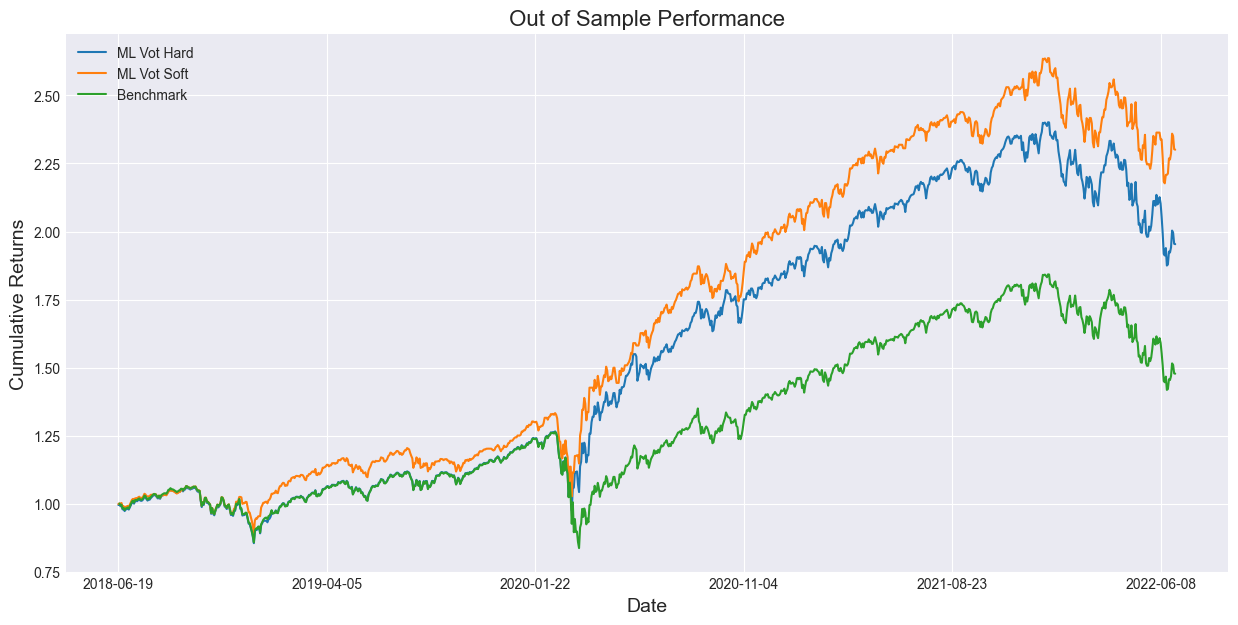

In [8]:
# Store predicted signal of hard voting classifier in column predicted_signal_hard
# of spy dataframe
spy['predicted_signal_hard'] = vot_hard.predict(scaler.transform(X))

# Store predicted signal of soft voting classifier in column predicted_signal_soft
# of spy dataframe
spy['predicted_signal_soft'] = vot_soft.predict(scaler.transform(X))

# Calculate both voting classifier model's strategy returns
spy['strategy_returns_hard'] = spy.Close.pct_change() * \
    spy.predicted_signal_hard.shift(1)
spy['strategy_returns_soft'] = spy.Close.pct_change() * \
    spy.predicted_signal_soft.shift(1)

# Store test data in test_data dataframe
split = int(0.7*len(X))
test_data = spy.iloc[split:]

# Calculate cumulative returns of strategy using signal from hard voting classifier model
(test_data['strategy_returns_hard'] +
 1).cumprod().plot(label='ML Vot Hard', figsize=(15, 7))

# Calculate cumulative returns of strategy using signal from soft voting classifier model
(test_data['strategy_returns_soft']+1).cumprod().plot(label='ML Vot Soft')

# Calculate cumulative returns of simple buy and hold strategy and use it as a benchmark
(test_data.Close.pct_change()+1).cumprod().plot(label='Benchmark')

# Define function to calculate sharpe ratio
def get_sr(ret):
    return round(ret.mean()/ret.std()*252**0.5, 2)

# Calculate and print sharpe ratio of all strategies
print(f"Benchmark SR: {get_sr(test_data.Close.pct_change())}")
print(f"Strategy Hard SR: {get_sr(test_data['strategy_returns_hard'])}")
print(f"Strategy Soft SR: {get_sr(test_data['strategy_returns_soft'])}")

# Set title
plt.title('Out of Sample Performance', fontsize=16)

# Set x and y axis labels
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend()
plt.show()

You can see that the cumulative returns of the soft voting classifier model outperformed both the hard voting classifier model and the benchmark. 

<a id='conclusion'></a>
## Conclusion

You have used multiple machine learning models, such as the XGBoost, Logistic Regression, and SVM,  to implement a voting classifier model. You implemented both hard and soft voting classifiers, checked the performance using the cumulative  returns criteria, and found that the soft voting classifier model gives better returns. 

You can tweak the strategy further by performing any or all of the following:
- Add or subtract other machine learning models
- Try different test-train split
- Try different ML models as the base learners<br><br>